# German Traffic Signs Recognition using CNN 



German Traffic Sign Recognition using CNN involves training a CNN model with a large dataset of images of German traffic signs, along with the corresponding labels indicating the type of sign present in each image. Once trained, the model can be used to classify new images of German traffic signs by making a prediction based on the features learned during training.






##About the Data :
*   Provided by the Real-time Computer Vision research group 
*   Shows images for different German traffic signs
*   Single-image multi-class classification problem 
*   More than 40 classes 
*   More than 50,000 images 
*   Large,lifelike database 



The size of data is large to uploade from a local machine or google drive so  
To fetch the data from kaggle directly using kaggle API :

1.    you need to have an account on kaggle 
2.    Do some steps on your kaggle account, Please check out this link:
https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/ 
3. After uploade (kaggle.json) file to the notebook
4. Just, run the cell below (#Fetching the data) and congrats you have the data to start the party👏😎


#Fetching Data

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
! unzip gtsrb-german-traffic-sign

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
gtsrb-german-traffic-sign.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  gtsrb-german-traffic-sign.zip
replace Meta.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#Library that we need
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# reading 
import pandas as pd
Train_images = pd.read_csv('/content/Train.csv')
Test_images = pd.read_csv('/content/Test.csv')
Meta_images = pd.read_csv('/content/Meta.csv')

In [ ]:
Train_images.head()

In [ ]:
#Roi.X1 : Upper left X coordinate of sign on image
#Roi.y1 : Upper left Y coordinate of sign on image
#Roi.X2 : Lower right X coordinate of sign on image
#Roi.y2 : Lower right Y coordinate of sign on image

# Useful in case to draw a rectangle around the signs 

In [ ]:
Meta_images.head()

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


In [ ]:
Train_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  int64 
 1   Height   39209 non-null  int64 
 2   Roi.X1   39209 non-null  int64 
 3   Roi.Y1   39209 non-null  int64 
 4   Roi.X2   39209 non-null  int64 
 5   Roi.Y2   39209 non-null  int64 
 6   ClassId  39209 non-null  int64 
 7   Path     39209 non-null  object
dtypes: int64(7), object(1)
memory usage: 2.4+ MB


In [ ]:
dataset_directory = '/content'


In [ ]:
import cv2
c = 0
for i in Train_images["ClassId"].sample(frac=1).reset_index(drop=True):  
  c += 1
  image1 = cv2.imread(Train_images["Path"][i])
  image_shape = image1.shape
  print(image_shape)
  if c==10:
    break


(28, 31, 3)
(31, 31, 3)
(27, 28, 3)
(45, 50, 3)
(28, 31, 3)
(34, 40, 3)
(54, 59, 3)
(36, 38, 3)
(34, 37, 3)
(33, 36, 3)


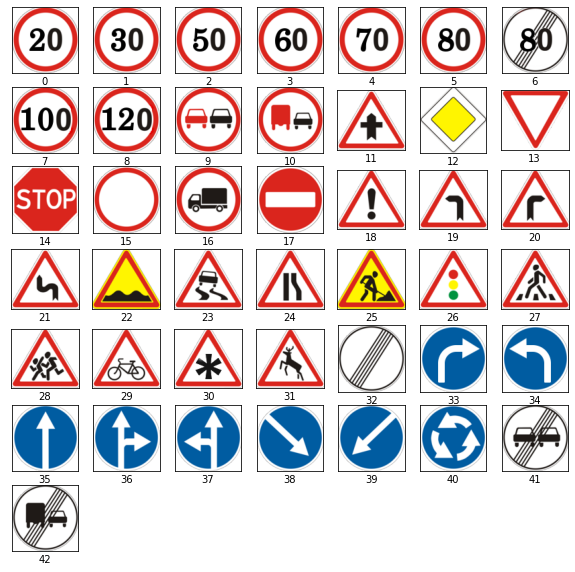

In [ ]:
# Show pictures of traffic sign and it's labels
plt.figure(figsize=(10, 10))
num = 0
for i in (Meta_images.sort_values(by=['ClassId']))['Path']:
    plt.subplot(7,7,num+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    path = dataset_directory +'/'+ i #"/meta/{}.png".format(i)
    img = plt.imread(path)
    plt.imshow(img)
    label =str( Meta_images[Meta_images['Path']==i]['ClassId'].values[0])
    plt.xlabel(label)
    num+=1

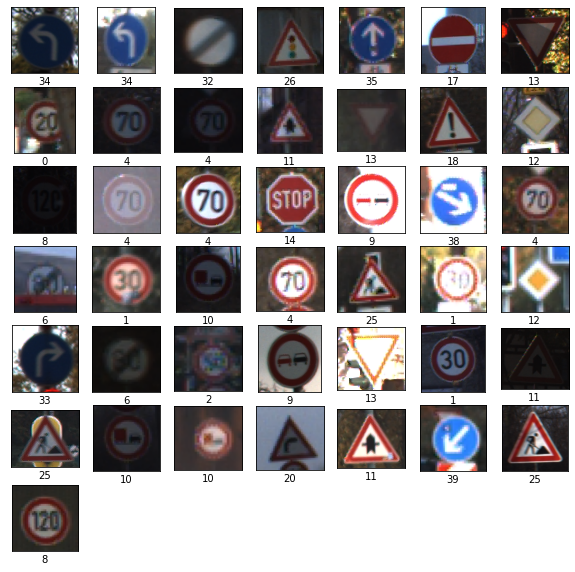

In [ ]:
# Show images of a traffic sign and it's labels 

plt.figure(figsize=(10, 10))
num = 0
for i in (Train_images.sample(frac = 1))['Path']:
    plt.subplot(7,7,num+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    path = dataset_directory +'/'+ i #"/meta/{}.png".format(i)
    img = plt.imread(path)
    plt.imshow(img)
    label = Train_images[Train_images['Path']==i]['ClassId'].values[0]
    plt.xlabel(label)
    num+=1
    if num == 43 :
      break


# Preprocessing Data

##List to Numpy Array

In [ ]:
# install MPI for Python
!pip install mpi4py

In [ ]:
# In case you work on multi-core machine , this code will be useful to minimize execution time
# MPI for Python provides Python bindings for the Message Passing Interface (MPI) 
# standard, allowing Python applications to exploit multiple processors on workstations, clusters and supercomputers.
# This package builds on the MPI specification and provides an object oriented 
# interface resembling the MPI-2 C++ bindings. It supports point-to-point (sends, receives)
# and collective (broadcasts, scatters, gathers) communication of any picklable Python object, 
# as well as efficient communication of Python objects exposing the Python buffer interface (e.g. NumPy arrays and builtin bytes/array/memoryview objects).


# converte images to numpy array and collect all of them in list 
 
%%time 
from mpi4py import MPI
import pandas as pd 
import csv
import numpy as np
import cv2

def split(a, n):
    k, m = divmod(len(a), n)
    return list(a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()


df = []
if rank == 0:
  MPI_data = []
  MPI_labels_new = []
  Train_images = pd.read_csv('/content/Train.csv')
  paths = split(np.array(Train_images['Path']), size)


Sub_data = []
recv_paths = []
Sub_labels = []


recv_data = comm.bcast(Train_images, root=0)
recv_paths = comm.scatter(paths, root=0)

for path in recv_paths:  
    try:
        image = cv2.imread(dataset_directory +'/'+ path)
        image_f = Image.fromarray(image, 'RGB')
        size_image = image_f.resize((30, 30))
        Sub_data.append(np.array(size_image))
        label = recv_data[recv_data['Path']==path]['ClassId'].values[0]
        Sub_labels.append(label)
        
        

        
    except:
        print("Error in " + path)
        break

MPI_data = comm.gather(Sub_data, root=0)
MPI_labels = comm.gather(Sub_labels, root=0)

if rank ==0 :
  sign = 0





In [ ]:
print(((np.array(MPI_data)).reshape(39209, 30, 30, 3)).shape)
print(((np.array(MPI_labels)).reshape(-1,)).shape)

(39209, 30, 30, 3)
(39209,)


In [ ]:
# convert lists to numpy array and reshaping it to be suitabl to split and the CNN model
MPI_data = (np.array(MPI_data)).reshape(39209, 30, 30, 3)
MPI_labels = (np.array(MPI_labels)).reshape(-1,)
MPI_data = np.array(MPI_data)
MPI_labels = np.array(MPI_labels)

In [ ]:
# In case you run the code on google colab /jupyter notebook ,use and run this cell
# The same taske done here with this code.Approximately, with total exceution time = 2.4 min
# [It could be (min/max)imum  on different machine, that depends on the computationl power] 

# %%time 
# import numpy as np
# import matplotlib.image as mpimg

# data = []
# labels = []

# for path in Train_images['Path']:
#         try:
#             image = mpimg.imread(dataset_directory + '/' + path)
#             image_f = Image.fromarray(image, 'RGB')
#             size_image = image_f.resize((30, 30))
#             data.append(np.array(size_image))
#             label = Train_images[Train_images['Path']==path]['ClassId'].values[0]
#             labels.append(label)
#         except:
#             print("Error in " + img)
#             break

# data = np.array(data)
# labels = np.array(labels)

# sign = 1  

#2.4s

##Shuffling

In [ ]:
# Shuffling the data of images and it's label to avoid overfitting 
# Shuffling is done in the same order in which images will still match the right label  
# { Example below on the functionality how does it work}
if sign == 0 :
  used_data = MPI_data
  used_labels = MPI_labels
  shuffle_indexes = np.arange(used_data.shape[0])
  np.random.shuffle(shuffle_indexes)
  used_data = used_data[shuffle_indexes]
  used_labels = used_labels[shuffle_indexes]


else :
  used_data = data
  used_labels = labels
  shuffle_indexes = np.arange(used_data.shape[0])
  np.random.shuffle(shuffle_indexes)
  used_data = used_data[shuffle_indexes]
  used_labels = used_labels[shuffle_indexes]

In [ ]:
# Example-1
import numpy as np
a = np.arange(100,200)
shuffle_indexes = np.arange(a.shape[0])
np.random.shuffle(shuffle_indexes)
b = a[shuffle_indexes]
print("Shuffling order =>\n",shuffle_indexes)
print('-'*80)
print("array a before suffling =>\n",a)
print('-'*80)
print( "array a after shuffling =>\n",b)

Shuffling order =>
 [92 91 55  8 32 72 12  0 29 90 59 33 46 21 20 60 45 50 79 27 71 87 93 34
  1 35  7  2  5 77 10 48 15 76 67 95 13 58 57 83 53 19 11 69 82 62 49 73
 98 26 30 25 42 14 38 70 61 75  3 97 74 52 41 39 63 85 99 66 51 65 88 23
 31 86  6 54 17 81 40  4 84 44  9 56 22 78 96 64 68 24 28 89 16 80 47 36
 94 37 18 43]
--------------------------------------------------------------------------------
array a before suffling =>
 [100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199]
--------------------------------------------------------------------------------
array a after shuffling =>
 [192 191 155 108 132 172 112 100 129 190 159 133 

##Splittng, Scaling and Encoding  

In [ ]:
#Splitting the data to go throw next step , Building the CNN model
x_train, x_val, y_train, y_val = train_test_split(used_data,used_labels, test_size=0.3, random_state=42, shuffle=True)

#scaling the data
x_train = x_train/255 
x_val = x_val/255

print("X_train.shape", x_train.shape)
print("X_valid.shape", x_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


In [ ]:
#encode the labels to fit with the model
y_train = keras.utils.to_categorical(y_train, 43)
y_val = keras.utils.to_categorical(y_val, 43)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


In [ ]:
model0 = tf.keras.models.Sequential([
     keras.layers.Flatten(),
     keras.layers.Dense(512,activation='relu'),
     keras.layers.Normalization(),
     keras.layers.Dense(256,activation='relu'),
     keras.layers.Dropout(0.5),
     keras.layers.Dense(128,activation='relu'),
     keras.layers.Dense(64,activation='relu'),
     keras.layers.Dropout(0.5),
     keras.layers.Dense(43, activation='softmax')

])

model0.compile(loss='categorical_crossentropy',
               optimizer="SGD",
                metrics=['accuracy'])
history = model0.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
858/858 [==============================] - 5s 6ms/step - loss: 3.5241 - accuracy: 0.0873 - val_loss: 3.1714 - val_accuracy: 0.2721
Epoch 2/10
858/858 [==============================] - 5s 6ms/step - loss: 3.0105 - accuracy: 0.2204 - val_loss: 2.5717 - val_accuracy: 0.4198
Epoch 3/10
858/858 [==============================] - 5s 5ms/step - loss: 2.5013 - accuracy: 0.3290 - val_loss: 1.9406 - val_accuracy: 0.4631
Epoch 4/10
858/858 [==============================] - 4s 4ms/step - loss: 2.1204 - accuracy: 0.4021 - val_loss: 1.8528 - val_accuracy: 0.4533
Epoch 5/10
858/858 [==============================] - 4s 4ms/step - loss: 1.8499 - accuracy: 0.4569 - val_loss: 1.4136 - val_accuracy: 0.5813
Epoch 6/10
858/858 [==============================] - 4s 5ms/step - loss: 1.6515 - accuracy: 0.5037 - val_loss: 1.2126 - val_accuracy: 0.6554
Epoch 7/10
858/858 [==============================] - 4s 4ms/step - loss: 1.4911 - accuracy: 0.5460 - val_loss: 1.0301 - val_accuracy: 0.6841
Epoch 

In [ ]:
model1 = tf.keras.models.Sequential([
     keras.layers.Flatten(),
     keras.layers.Dense(512,activation='relu'),
     keras.layers.Normalization(),
     keras.layers.Dense(256,activation='relu'),
     keras.layers.Dropout(0.5),
     keras.layers.Dense(128,activation='relu'),
     keras.layers.Dense(64,activation='relu'),
     keras.layers.Dropout(0.5),
     keras.layers.Dense(43, activation='softmax')

])

model1.compile(loss='categorical_crossentropy',
               optimizer="Adam",
                metrics=['accuracy'])
history = model1.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
858/858 [==============================] - 5s 5ms/step - loss: 3.2334 - accuracy: 0.1239 - val_loss: 2.3232 - val_accuracy: 0.3094
Epoch 2/10
858/858 [==============================] - 4s 5ms/step - loss: 2.1924 - accuracy: 0.3207 - val_loss: 1.7313 - val_accuracy: 0.4320
Epoch 3/10
858/858 [==============================] - 4s 4ms/step - loss: 1.7440 - accuracy: 0.4356 - val_loss: 1.3402 - val_accuracy: 0.5391
Epoch 4/10
858/858 [==============================] - 4s 5ms/step - loss: 1.4999 - accuracy: 0.5043 - val_loss: 1.1176 - val_accuracy: 0.6176
Epoch 5/10
858/858 [==============================] - 4s 5ms/step - loss: 1.2680 - accuracy: 0.5836 - val_loss: 0.9052 - val_accuracy: 0.7131
Epoch 6/10
858/858 [==============================] - 4s 4ms/step - loss: 1.1312 - accuracy: 0.6304 - val_loss: 0.8022 - val_accuracy: 0.7501
Epoch 7/10
858/858 [==============================] - 4s 4ms/step - loss: 1.0277 - accuracy: 0.6645 - val_loss: 0.7621 - val_accuracy: 0.7437
Epoch 

In [ ]:
from tensorflow.keras.layers import LeakyReLU

model2 = tf.keras.models.Sequential([
     keras.layers.Flatten(),
     keras.layers.Dense(512,activation=LeakyReLU()),
     keras.layers.Normalization(),
     keras.layers.Dense(256,activation=LeakyReLU()),
     keras.layers.Dropout(0.5),
     keras.layers.Dense(128,activation=LeakyReLU()),
     keras.layers.Dense(64,activation=LeakyReLU()),
     keras.layers.Dropout(0.5),
     keras.layers.Dense(43, activation='softmax')

])


model2.compile(loss='categorical_crossentropy',
               optimizer="Adam",
                metrics=['accuracy'])
history = model2.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val))



Epoch 1/10
858/858 [==============================] - 5s 5ms/step - loss: 2.7358 - accuracy: 0.2741 - val_loss: 1.5723 - val_accuracy: 0.5098
Epoch 2/10
858/858 [==============================] - 4s 5ms/step - loss: 1.5278 - accuracy: 0.5479 - val_loss: 0.9612 - val_accuracy: 0.7441
Epoch 3/10
858/858 [==============================] - 4s 4ms/step - loss: 1.1426 - accuracy: 0.6576 - val_loss: 0.7977 - val_accuracy: 0.7584
Epoch 4/10
858/858 [==============================] - 4s 5ms/step - loss: 0.9621 - accuracy: 0.7135 - val_loss: 0.8030 - val_accuracy: 0.7558
Epoch 5/10
858/858 [==============================] - 4s 5ms/step - loss: 0.8651 - accuracy: 0.7460 - val_loss: 0.5541 - val_accuracy: 0.8279
Epoch 6/10
858/858 [==============================] - 4s 4ms/step - loss: 0.7920 - accuracy: 0.7688 - val_loss: 0.6479 - val_accuracy: 0.7859
Epoch 7/10
858/858 [==============================] - 4s 4ms/step - loss: 0.7481 - accuracy: 0.7831 - val_loss: 0.5250 - val_accuracy: 0.8500
Epoch 

#Pretrained Model => ResNet50

In [ ]:
used_labels
used_data

In [ ]:
model_A = keras.applications.resnet50.ResNet50(weights='imagenet')
resized = tf.image.resize( used_data ,[224 , 224])
new_data = keras.applications.resnet50.preprocess_input(resized)
preds = model_A.predict(new_data)




#Build CNN Model 

In [ ]:
earlyStop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.003,
    patience=4,
    verbose=0,
    mode='max',
    restore_best_weights=True,

)
model = tf.keras.models.Sequential([
 tf.keras.layers.Conv2D(filters=64, kernel_size=(4,4), activation='relu', input_shape=(30,30,3)),
 tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
 tf.keras.layers.Conv2D(filters=64, kernel_size=(4,4), activation='relu',padding="same"),
 tf.keras.layers.Dropout(0.5),
 tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), activation='relu',padding="valid"),
 tf.keras.layers.MaxPool2D(),
 tf.keras.layers.Conv2D(filters=16, kernel_size=(4,4), activation='relu',padding="same"),
 tf.keras.layers.Flatten(),
 tf.keras.layers.Normalization(),
 tf.keras.layers.Dense(1024, activation='relu'),
 tf.keras.layers.Dropout(0.5),
 tf.keras.layers.Dense(43, activation='softmax')])

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

##Model Results

In [ ]:
history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_val, y_val), callbacks=[earlyStop])

Epoch 1/20
858/858 [==============================] - 18s 7ms/step - loss: 1.1978 - accuracy: 0.6557 - val_loss: 0.1917 - val_accuracy: 0.9385
Epoch 2/20
858/858 [==============================] - 6s 6ms/step - loss: 0.2227 - accuracy: 0.9311 - val_loss: 0.0928 - val_accuracy: 0.9726
Epoch 3/20
858/858 [==============================] - 5s 6ms/step - loss: 0.1439 - accuracy: 0.9549 - val_loss: 0.0580 - val_accuracy: 0.9834
Epoch 4/20
858/858 [==============================] - 6s 7ms/step - loss: 0.1028 - accuracy: 0.9682 - val_loss: 0.0584 - val_accuracy: 0.9834
Epoch 5/20
858/858 [==============================] - 6s 6ms/step - loss: 0.0915 - accuracy: 0.9722 - val_loss: 0.0579 - val_accuracy: 0.9844
Epoch 6/20
858/858 [==============================] - 6s 7ms/step - loss: 0.0832 - accuracy: 0.9742 - val_loss: 0.0512 - val_accuracy: 0.9861
Epoch 7/20
858/858 [==============================] - 5s 6ms/step - loss: 0.0736 - accuracy: 0.9770 - val_loss: 0.0401 - val_accuracy: 0.9874
Epoch

In [ ]:
#From some notebook on the competition
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [ ]:
def getX_test(Image_Path):
  image_test = cv2.imread( Image_Path)
  image_f_test = Image.fromarray(image_test, 'RGB')
  size_image_test = image_f_test.resize((30, 30))
  image_data_test = np.array(size_image_test)

  x_test_show = np.array(image_data_test)
  x_test = x_test_show/255
  x_test=x_test.reshape(-1,30,30,3)
  
  return x_test, x_test_show


def predictClass(model, Image_Path : str, dict_of_signs_label):
  x_test,x_test_show = getX_test(Image_Path)

  prediction = model.predict(x_test)
  index=np.argmax(prediction , axis=1)
  plt.imshow(x_test_show)
  print('Class :',index ,' ==> {',dict_of_signs_label[index[0]],'}')

1/1 [==============================] - 0s 163ms/step
Class : [3]  ==> { Speed limit (60km/h) }


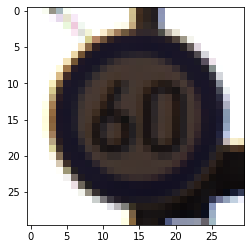

In [ ]:
predictClass(model,'/content/Test/00700.png',classes)

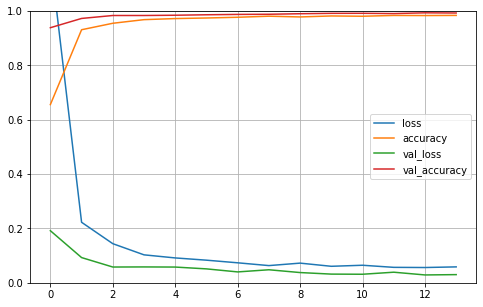

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

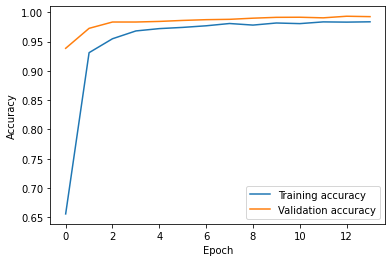

In [ ]:
plt.plot(history.history['accuracy'], 
         label='Training accuracy')
plt.plot(history.history['val_accuracy'], 
         label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

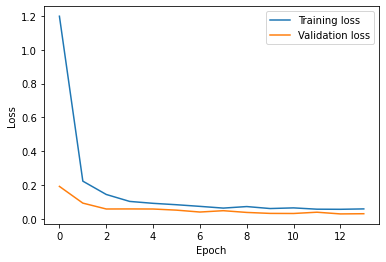

In [ ]:
plt.plot(history.history['loss'], 
         label='Training loss')
plt.plot(history.history['val_loss'], 
         label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Saving Best Model 

In [ ]:
import pickle
pickle.dump(model,open('/content/BestModel.pkl','wb') )
saved_model = pickle.load(open('/content/BestModel.pkl','rb'))


1/1 [==============================] - 0s 75ms/step
Class : [14]  ==> { Stop }


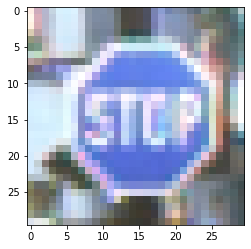

In [ ]:
predictClass(saved_model,"/content/Test/00167.png",classes)